# EMNIST Character Recognition
This notebook walks through **Part 1 (Dense Neural Network)** and **Part 2 (Convolutional Neural Network)** to classify handwritten letters from the EMNIST dataset.

Run every cell top‑to‑bottom (or use *Run All*). All heavy lifting is done with **TensorFlow/Keras**.

## Setup and Installation

In [30]:

# ── Install requirements (uncomment on first run / Colab) ──
# !pip install tensorflow tensorflow-datasets scikit-learn matplotlib seaborn --quiet

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Matplotlib style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Result folders
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)


## 1. Data Loading and Preprocessing

INFO:absl:Load dataset info from C:\Users\ericy\tensorflow_datasets\emnist\letters\3.1.0
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\ericy\tensorflow_datasets\emnist\letters\3.1.0.
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\ericy\tensorflow_datasets\emnist\letters\3.1.0.
INFO:absl:Constructing tf.data.Dataset emnist for split ['train', 'test'], from C:\Users\ericy\tensorflow_datasets\emnist\letters\3.1.0


Training data shape: (88800, 28, 28)
Test data shape    : (14800, 28, 28)


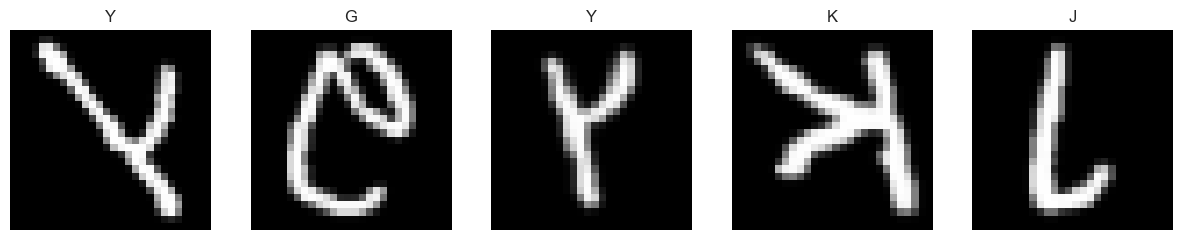

In [31]:

# ── Load EMNIST letters via TensorFlow Datasets ──
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
    batch_size=-1        # load entire split into memory
)

(x_train, y_train), (x_test, y_test) = [tfds.as_numpy(ds) for ds in (ds_train, ds_test)]

# ── Fix orientation (rotate +90° and mirror) ──
x_train = np.flip(x_train.transpose(0, 2, 1, 3), axis=2).squeeze(-1)
x_test  = np.flip(x_test.transpose(0, 2, 1, 3), axis=2).squeeze(-1)

# Shift labels from 1‑26 to 0‑25
y_train -= 1
y_test  -= 1

print('Training data shape:', x_train.shape)
print('Test data shape    :', x_test.shape)

# ── Visualise a few samples ──
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(chr(y_train[i] + 65))
    plt.axis('off')
plt.show()


### Preprocess for Dense Neural Network

In [32]:

# Normalise to [0‑1] and flatten
x_train_flat = (x_train / 255.0).astype('float32').reshape(-1, 28 * 28)
x_test_flat  = (x_test  / 255.0).astype('float32').reshape(-1, 28 * 28)

# One‑hot labels
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=26)
y_test_oh  = tf.keras.utils.to_categorical(y_test,  num_classes=26)

# Train/val split
x_train_flat, x_val_flat, y_train_oh, y_val_oh = train_test_split(
    x_train_flat, y_train_oh, test_size=0.2, random_state=42
)

print('Train:', x_train_flat.shape, ' Val:', x_val_flat.shape)


Train: (71040, 784)  Val: (17760, 784)


## 2. Model Implementation – Dense Neural Network

In [33]:

def create_simple_nn(input_shape=(784,), num_classes=26,
                     hidden_units=(512, 256),
                     dropout_rate=0.3,
                     lr=1e-3):
    """Two‑layer MLP with dropout."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(hidden_units[0], activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(hidden_units[1], activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

dnn_model = create_simple_nn()
dnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,930 (2.06 MB)

 Trainable params: 539,930 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training – Dense Neural Network

In [34]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    tf.keras.callbacks.ModelCheckpoint('models/emnist_dnn.keras', save_best_only=True)
]

history_dnn = dnn_model.fit(
    x_train_flat, y_train_oh,
    validation_data=(x_val_flat, y_val_oh),
    epochs=20,
    batch_size=256,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/20
278/278 - 3s - 10ms/step - accuracy: 0.6664 - loss: 1.1181 - val_accuracy: 0.8246 - val_loss: 0.5707 - learning_rate: 1.0000e-03
Epoch 2/20
278/278 - 2s - 8ms/step - accuracy: 0.8152 - loss: 0.5928 - val_accuracy: 0.8648 - val_loss: 0.4291 - learning_rate: 1.0000e-03
Epoch 3/20
278/278 - 2s - 8ms/step - accuracy: 0.8496 - loss: 0.4748 - val_accuracy: 0.8841 - val_loss: 0.3659 - learning_rate: 1.0000e-03
Epoch 4/20
278/278 - 2s - 8ms/step - accuracy: 0.8677 - loss: 0.4096 - val_accuracy: 0.8940 - val_loss: 0.3351 - learning_rate: 1.0000e-03
Epoch 5/20
278/278 - 2s - 8ms/step - accuracy: 0.8793 - loss: 0.3693 - val_accuracy: 0.8974 - val_loss: 0.3161 - learning_rate: 1.0000e-03
Epoch 6/20
278/278 - 5s - 17ms/step - accuracy: 0.8885 - loss: 0.3404 - val_accuracy: 0.9016 - val_loss: 0.3006 - learning_rate: 1.0000e-03
Epoch 7/20
278/278 - 4s - 13ms/step - accuracy: 0.8958 - loss: 0.3152 - val_accuracy: 0.9053 - val_loss: 0.2912 - learning_rate: 1.0000e-03
Epoch 8/20
278/278 - 4s 

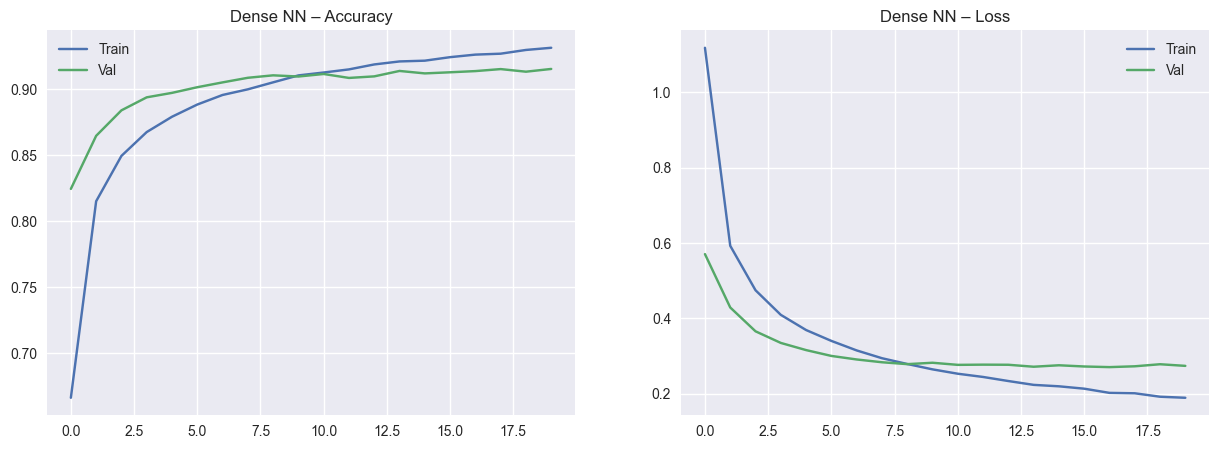

In [35]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_dnn.history['accuracy'], label='Train')
ax1.plot(history_dnn.history['val_accuracy'], label='Val')
ax1.set_title('Dense NN – Accuracy'); ax1.legend()

ax2.plot(history_dnn.history['loss'], label='Train')
ax2.plot(history_dnn.history['val_loss'], label='Val')
ax2.set_title('Dense NN – Loss'); ax2.legend()
plt.show()


Test accuracy (DNN): 0.9030
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


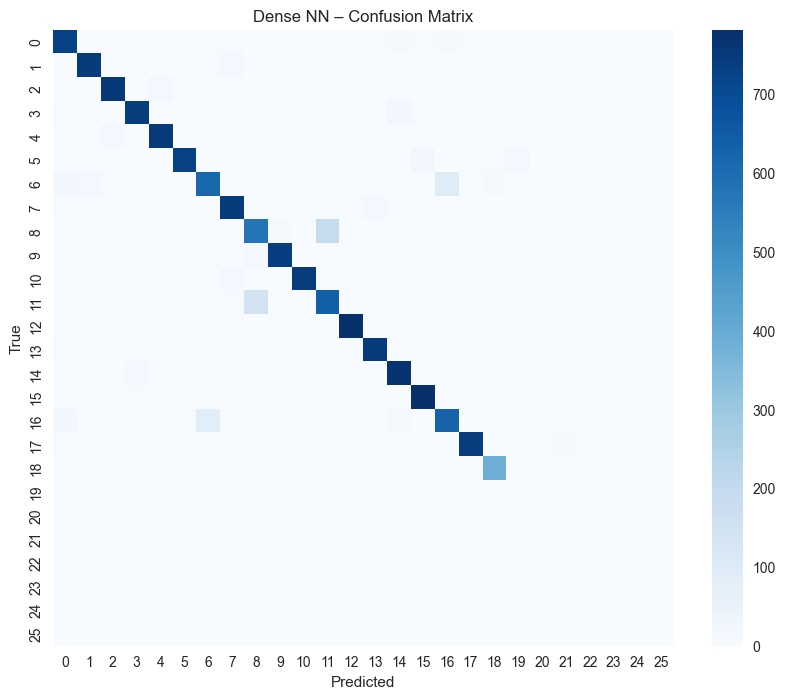

In [36]:

# Test set performance
test_loss_dnn, test_acc_dnn = dnn_model.evaluate(x_test_flat, y_test_oh, verbose=0)
print(f'Test accuracy (DNN): {test_acc_dnn:.4f}')

# Classification report & confusion matrix
y_pred_dnn = np.argmax(dnn_model.predict(x_test_flat, batch_size=1024), axis=1)
report_dnn = classification_report(y_test, y_pred_dnn, output_dict=True, zero_division=0)
precision_dnn = report_dnn['weighted avg']['precision']
recall_dnn    = report_dnn['weighted avg']['recall']
f1_dnn        = report_dnn['weighted avg']['f1-score']

cm_dnn = confusion_matrix(y_test, y_pred_dnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_dnn, cmap='Blues', annot=False)
plt.title('Dense NN – Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# Save metrics
metrics_dnn = {
    'model': 'emnist_dnn',
    'accuracy': float(test_acc_dnn),
    'precision': float(precision_dnn),
    'recall': float(recall_dnn),
    'f1_score': float(f1_dnn),
    'confusion_matrix': cm_dnn.tolist()
}
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics_dnn['model']}\n")
    f.write(f"accuracy: {metrics_dnn['accuracy']}\n")
    f.write(f"precision: {metrics_dnn['precision']}\n")
    f.write(f"recall: {metrics_dnn['recall']}\n")
    f.write(f"f1_score: {metrics_dnn['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics_dnn['confusion_matrix']}\n")
    f.write("----\n")
